In [6]:
# Import libraries
import moments, moments.LD
import pandas as pd, numpy as np
import demes, demesdraw, matplotlib.pylab as plt
import msprime as ms

import model, slice, get_LD, plot_LD

In [2]:
# Cake model function
def cake_model(Ns,splits,alpha1,alpha2,time_period_merge,time_period_splits,migration_rate=1e-4,yaml_filename=None,plot=True,plot_filename=None,time_units="generations",generation_time=1):
    """
    alpha1 = proportions of previous N for split
    alpha2 = propottions of contribution to mergerger per splitted deme
    """
    # Check arguments
    assert len(splits) == len(alpha1) == len(time_period_splits), "Proportions and time period list must be the same length as number of split events."
    assert len(splits)+1 == len(time_period_merge), "Time period merge list must be the same length as number of split events + 1."
    if time_units == "generations":
        generation_time=1
        
    merge_events = len(splits)+1
    assert len(Ns) == merge_events, "Length of Ns list must be equal to number of split events + 1"

    total_time = np.sum(np.array(time_period_merge).sum() + np.array(time_period_splits).sum())

    m = demes.Builder(time_units=time_units,generation_time=generation_time)

    # Add first Ancestor
    m.add_deme("Ancestral",epochs=[dict(start_size=Ns[0], end_time=total_time-time_period_merge[0])])
    current_time = total_time-time_period_merge[0]
    split_b = 1
    previous = ["Ancestral"]

    #
    event = 0 
    split_i = 0
    while current_time > 0:
        if split_b:
            pops = []
            assert splits[split_i] == len(alpha1[split_i]), "Proportions list must have the same length as the number of splits"
            for pop_i,proportion in zip(np.arange(splits[split_i]),alpha1[split_i]):
                name="Split_" + str(event) + str(pop_i)
                m.add_deme(name,ancestors=previous,start_time=current_time,epochs=[dict(start_size=Ns[event]*proportion,end_time=current_time-time_period_splits[event])])
                pops.append(name)
            previous = pops
            if migration_rate > 0:
                m.add_migration(demes = pops, rate = migration_rate)
            current_time = current_time-time_period_splits[event]
            split_b = 0
            event = event + 1
        else: 
            assert len(previous) == len(alpha1[split_i]),"Length of ancestors is not equal to proportions"
            proportion = alpha2[split_i] if len(previous) > 1 else [1]
            name="Merge_" + str(event)
            m.add_deme(name,ancestors=previous,proportions=proportion,start_time=current_time,epochs=[dict(start_size=Ns[event],end_time=current_time-time_period_merge[event])])
            previous = [name]
            current_time = current_time-time_period_merge[event]
            split_b = 1
            split_i = split_i + 1

    # Resolve model
    graph = m.resolve()

    # Check demographic events
    print(graph.discrete_demographic_events()['splits'])

    # option to save to yaml
    if yaml_filename != None:
        demes.dump(graph, yaml_filename, format='yaml', simplified=True)
    
    if plot:
        p = demesdraw.tubes(graph, log_time=False, num_lines_per_migration=3)
        if plot_filename != None:
            p.figure.savefig(plot_filename+".pdf")
    
    return graph

In [3]:
def plot_iicr(iirc,T): 
    plt.plot(T, iirc)
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("time ago (years)",fontsize = 14)
    plt.ylabel(r"IICR",fontsize = 14)
    
def plot_comparison(LDpop1,LDpop2,labels=["Original","Size Change"]):
    rhos = np.logspace(-2, 2, 21)
    
    # plot D2
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    ax.plot(rhos,LDpop1[:,0],label=labels[0])
    ax.plot(rhos,LDpop2[:,0],label=labels[1])
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"$\sigma_d^2$")
    ax.set_xlabel(r"$\rho$")

    # plot DZ
    ax2.plot(rhos,LDpop1[:,1],label=labels[0])
    ax2.plot(rhos,LDpop2[:,1],label=labels[1])
    ax2.legend()
    ax2.set_yscale("log")
    ax2.set_xscale("log")
    ax2.set_ylabel(r"$\sigma_{Dz}$")
    ax2.set_xlabel(r"$\rho$")

    plt.tight_layout()
    plt.show()

In [4]:
# alpha_1 refers to the proportions of the split with alpha_1 + (1-alpha_1) = 1, 1  being the total N
# alpha_2 refers to the proportions of contribution to the merged population
alpha_1 = np.linspace(0.01,0.99,40)
alpha_2 = alpha_1.copy()

In [9]:
N=11.5e3

[Split(parent='Ancestral', children=['Split_00', 'Split_01'], time=100000.0)]


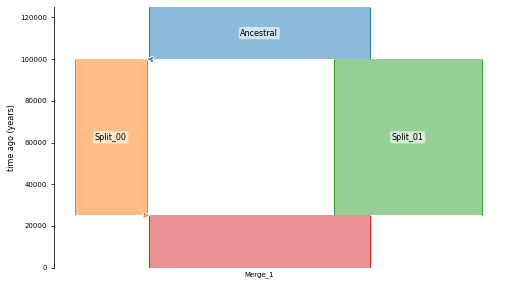

In [34]:
bubble = cake_model(Ns=[N,N],splits=[2],alpha1=[[0.33,0.67]],alpha2=[[0.819,0.181]],time_period_merge=[1e6,25e3],time_period_splits=[75e3],migration_rate=0,time_units="years",generation_time=29)

In [60]:
# Sample times at epochs
T,times_dic = slice.sample_timepoints(bubble,anc_end_time=1e6)
# Compute LD 
b_sliced = slice.slice_timepoints(bubble,time_points=[0])
b_sliced_LD = get_LD.get_LD_from_sliced_demes(b_sliced)

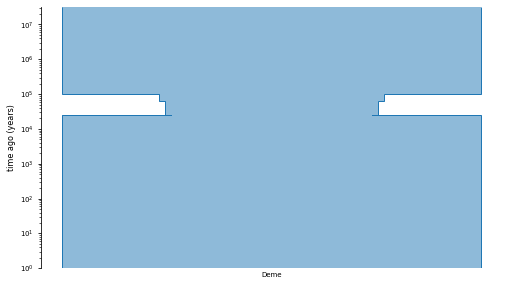

In [62]:
# Get IIRC
b_R, b_iicr, _ = model.get_iicr(bubble,pop="Merge_1",T=T/29)
b_sc = model.size_change_from_iicr(b_iicr,T,time_units="years",generation_time=29,plot=True)

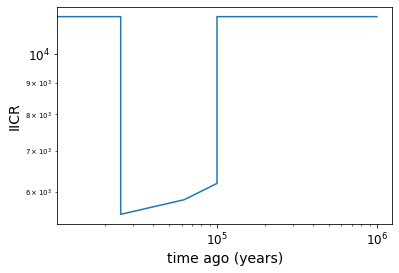

In [63]:
plot_iicr(b_iicr,T)

In [65]:
# Slice the generated model and get LD
b_sc_sliced = slice.slice_timepoints(b_sc,time_points=[0])
b_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(b_sc_sliced)

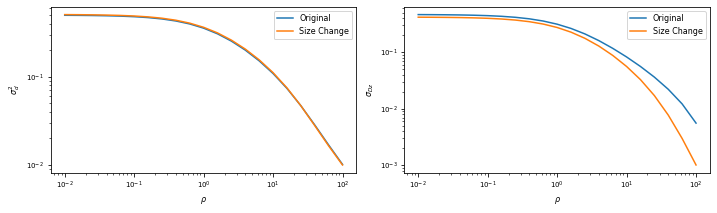

In [67]:
plot_comparison(b_sliced_LD['Merge_1'][-1],b_sc_sliced_LD['Deme'][-1])

In [134]:
x = b_sliced_LD['Merge_1'][-1][:,1] # Model
y = b_sc_sliced_LD['Deme'][-1][:,1] # size change

In [135]:
## area calculation
rhos = np.logspace(-2, 2, 21)
diff = np.abs(x - y) # calculate difference
area = np.trapz(y=diff, x=rhos)

In [18]:
def calculate_signal_area(LDpop1,LDpop2,rhos=np.logspace(-2, 2, 21)):
    x = LDpop1[:,1]
    y = LDpop2[:,1]
    diff = np.abs(x - y) # calculate difference
    area = np.trapz(y=diff, x=rhos)
    return area

def calculate_signal_Dz(LDpop1,LDpop2):
    '''Calculates the Mean log difference between the two decays of Dz'''
    x = LDpop1[:,1]
    y = LDpop2[:,1]
    log_diff = np.diff(np.log(x) - np.log(y)) # calculate difference
    mld= np.mean(log_diff)
    return mld

def calculate_signal_D2(LDpop1,LDpop2):
    '''Calculates the Mean log difference between the two decays of D2'''
    x = LDpop1[:,0]
    y = LDpop2[:,0]
    log_diff = np.diff(np.log(x) - np.log(y)) # calculate difference
    mld= np.mean(log_diff)
    return mld


In [7]:
def run_alpha_experiment(alpha1=[0.33,0.67],alpha2=[0.819,0.181],plot=False):
    bubble = cake_model(Ns=[N,N],splits=[2],alpha1=[alpha1],alpha2=[alpha2],time_period_merge=[1e6,25e3],time_period_splits=[75e3],migration_rate=0,time_units="years",generation_time=29,plot=False)
    # Sample times at epochs
    T,_ = slice.sample_timepoints(bubble,anc_end_time=1e6)
    # Compute LD 
    b_sliced = slice.slice_timepoints(bubble,time_points=[0])
    b_sliced_LD = get_LD.get_LD_from_sliced_demes(b_sliced)
    # Get IIRC
    _, b_iicr, _ = model.get_iicr(bubble,pop="Merge_1",T=T/29)
    b_sc = model.size_change_from_iicr(b_iicr,T,time_units="years",generation_time=29,plot=False)
    # Slice the generated model and get LD
    b_sc_sliced = slice.slice_timepoints(b_sc,time_points=[0])
    b_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(b_sc_sliced)
    # Get signal magnitude
    x = b_sliced_LD['Merge_1'][-1] # Model
    y = b_sc_sliced_LD['Deme'][-1] # size change
    if plot:
        plot_comparison(x,y)
        plot_iicr(b_iicr,T)
    return calculate_signal(x,y)

In [29]:
# alpha_1 refers to the proportions of the split with alpha_1 + (1-alpha_1) = 1, 1  being the total N
# alpha_2 refers to the proportions of contribution to the merged population
alpha_1 = np.linspace(0.1,0.9,10)
alpha_2 = alpha_1.copy()

In [30]:
alpha_1

array([0.1       , 0.18888889, 0.27777778, 0.36666667, 0.45555556,
       0.54444444, 0.63333333, 0.72222222, 0.81111111, 0.9       ])

In [31]:
np.empty(shape=(3,2))

array([[0.  , 0.02],
       [0.04, 0.06],
       [0.08, 0.1 ]])

In [ ]:
#alpha_1 = [0.25,0.75]
#alpha_2 = [0.25,0.75]
matrix = np.empty(shape=(0,len(alpha_2)))
for alpha1 in alpha_1:
    a2_l=[]
    for alpha2 in alpha_2:
        print(alpha1,alpha2)
        signal = run_alpha_experiment(alpha1=[alpha1,1-alpha1],alpha2=[alpha2,1-alpha2],plot=True)
        a2_l.append(signal)
    matrix = np.append(matrix,[a2_l],axis=0)    


In [195]:
np.round(alpha_2,3)

array([0.1  , 0.189, 0.278, 0.367, 0.456, 0.544, 0.633, 0.722, 0.811,
       0.9  ])

In [33]:
df_matrix = pd.DataFrame(matrix, index = np.round(alpha_2,3),
                  columns =np.round(alpha_1,3))

In [34]:
df_matrix

,0.100,0.189,0.278,0.367,0.456,0.544,0.633,0.722,0.811,0.900
0.100,0.007925,0.014506,0.055076,0.092281,0.115748,0.127787,0.131465,0.129256,0.122793,0.111169
0.189,0.016771,0.007346,0.014970,0.045562,0.075039,0.095315,0.106730,0.110581,0.107316,0.093911
0.278,0.025532,0.017749,0.007029,0.015119,0.040151,0.064269,0.080982,0.089646,0.089938,0.078387
0.367,0.034166,0.030795,0.017241,0.006869,0.015423,0.036958,0.056839,0.069578,0.073525,0.065002
0.456,0.043296,0.044288,0.033124,0.016533,0.006801,0.015903,0.034866,0.050769,0.058391,0.053431
0.544,0.053431,0.058391,0.050769,0.034866,0.015903,0.006801,0.016533,0.033124,0.044288,0.043296
0.633,0.065002,0.073525,0.069578,0.056839,0.036960,0.015423,0.006869,0.017241,0.030795,0.034166
0.722,0.078387,0.089938,0.089646,0.080982,0.064269,0.040153,0.015119,0.007029,0.017749,0.025532
0.811,0.093911,0.107316,0.110581,0.106730,0.095315,0.075039,0.045562,0.014970,0.007346,0.016771
0.900,0.111170,0.122793,0.129256,0.131464,0.127787,0.115748,0.092281,0.055078,0.014506,0.007925


In [35]:
import seaborn as sns

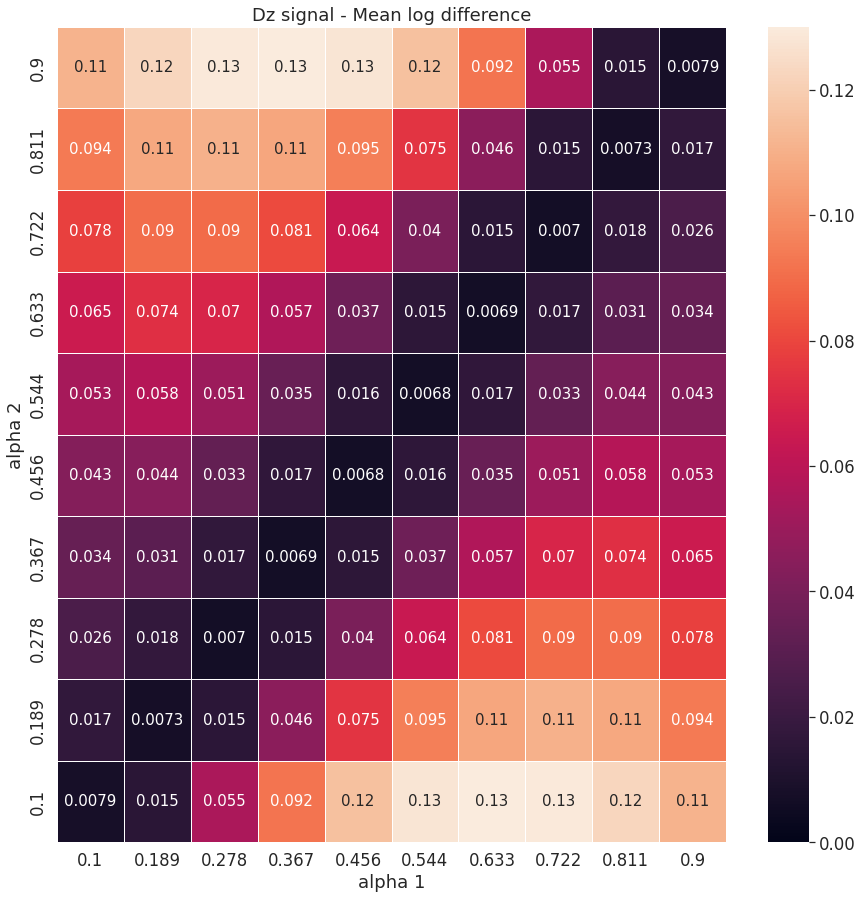

In [38]:
plt.figure(figsize=(15,15))
sns.set(font_scale=1.5)
heat_map = sns.heatmap(df_matrix, linewidth = 1 , annot = True,vmax=np.max(matrix).round(2),vmin=0,annot_kws={"fontsize":15})
heat_map.invert_yaxis()
plt.xlabel("alpha 1")
plt.ylabel("alpha 2")
plt.title( "Dz signal - Mean log difference" )
plt.show()

In [3]:
def p_coal_t_given_not_coal(t,N,a1,a2):
    p = (a2**2 * (1 - 1/(2*a1*N))**(t-1) * 1/(2*a1*N) + (1-a2)**2 * (1 - (1/(2*(1-a1)*N)))**(t-1) * (1/(2*(1-a1)*N))) / (a2**2 * (1 - 1/(2*a1*N))**(t-1) + (1-a2)**2 * (1 - (1/(2*(1-a1)*N)))**(t-1) + 2*a2*(1-a2))
    return(p)

In [29]:
Ts = np.concatenate([
    np.linspace(0, 1000, 2001),
    np.linspace(1000, 1e6, 1001)[1:]
])

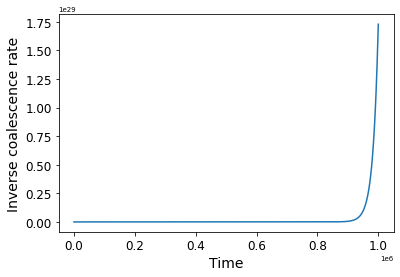

In [30]:
#alpha_1 = [0.25,0.75]
#alpha_2 = [0.25,0.75]
ps=[]
for t in Ts:
    ps.append(p_coal_t_given_not_coal(t,N=11.5e3,a1=0.25,a2=0.25))

plt.plot(Ts, 1/np.array(ps))
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.xlabel("Time",fontsize = 14)
plt.ylabel(r"Inverse coalescence rate",fontsize = 14);

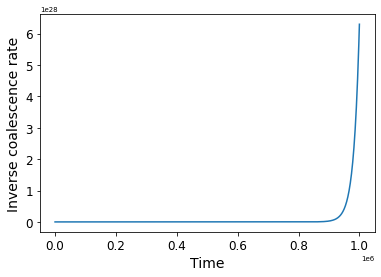

In [31]:
ps=[]
for t in Ts:
    ps.append(p_coal_t_given_not_coal(t,N=11.5e3,a1=0.20,a2=0.81))

plt.plot(Ts, 1/np.array(ps))
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.xlabel("Time",fontsize = 14)
plt.ylabel(r"Inverse coalescence rate",fontsize = 14);